In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
user = pd.read_csv('./data/Funnel/user_table.csv', parse_dates=['date'])
user.head()

,user_id,date,device,sex
0,450007,2015-02-28,Desktop,Female
1,756838,2015-01-13,Desktop,Male
2,568983,2015-04-09,Desktop,Male
3,190794,2015-02-18,Desktop,Female
4,537909,2015-01-15,Desktop,Male


In [3]:
home = pd.read_csv('./data/Funnel/home_page_table.csv')
home.head()

,user_id,page
0,313593,home_page
1,468315,home_page
2,264005,home_page
3,290784,home_page
4,639104,home_page


In [4]:
search = pd.read_csv('./data/Funnel/search_page_table.csv')
search.head()

,user_id,page
0,15866,search_page
1,347058,search_page
2,577020,search_page
3,780347,search_page
4,383739,search_page


In [5]:
payment = pd.read_csv('./data/Funnel/payment_page_table.csv')
payment.head()

,user_id,page
0,253019,payment_page
1,310478,payment_page
2,304081,payment_page
3,901286,payment_page
4,195052,payment_page


In [6]:
confirm = pd.read_csv('./data/Funnel/payment_confirmation_table.csv')
confirm.head()

,user_id,page
0,123100,payment_confirmation_page
1,704999,payment_confirmation_page
2,407188,payment_confirmation_page
3,538348,payment_confirmation_page
4,841681,payment_confirmation_page


# Data Processing

In [7]:
data = pd.merge(left=user, right=home, how='left', on='user_id')
data = pd.merge(left=data, right=search, how='left', on='user_id', suffixes=('_home', '_search'))
data = pd.merge(left=data, right=payment, how='left', on='user_id')
data = pd.merge(left=data, right=confirm, how='left', on='user_id', suffixes=('_payment', '_confirmation'))
data.head()

,user_id,date,device,sex,page_home,page_search,page_payment,page_confirmation
0,450007,2015-02-28,Desktop,Female,home_page,NaN,NaN,NaN
1,756838,2015-01-13,Desktop,Male,home_page,NaN,NaN,NaN
2,568983,2015-04-09,Desktop,Male,home_page,search_page,NaN,NaN
3,190794,2015-02-18,Desktop,Female,home_page,search_page,NaN,NaN
4,537909,2015-01-15,Desktop,Male,home_page,NaN,NaN,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90400 entries, 0 to 90399
Data columns (total 8 columns):
user_id              90400 non-null int64
date                 90400 non-null datetime64[ns]
device               90400 non-null object
sex                  90400 non-null object
page_home            90400 non-null object
page_search          45200 non-null object
page_payment         6030 non-null object
page_confirmation    452 non-null object
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 6.2+ MB


# Analysis

### Visit Probability for Each Page

In [9]:
conv_ratio = 1 - pd.DataFrame(data.isnull().sum()).rename(columns={0: 'conversion'}) / len(data)
conv_ratio = conv_ratio.reset_index()[4:]
conv_ratio

,index,conversion
4,page_home,1.000000
5,page_search,0.500000
6,page_payment,0.066704
7,page_confirmation,0.005000


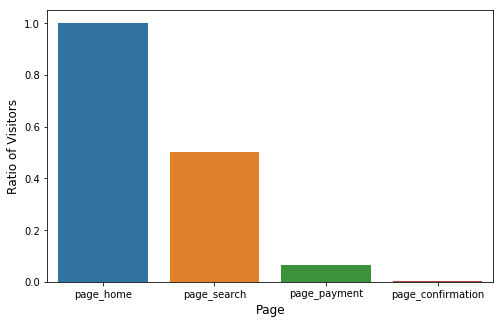

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='index', y='conversion', data=conv_ratio, ax=ax)
ax.set_xlabel('Page', fontsize=12)
ax.set_ylabel('Ratio of Visitors', fontsize=12)
plt.show()

### Conversion Rate for Each Page

In [11]:
def conversion_rate(df):
    """ function to calculate conversion rates for home, search and payment page"""
    rates = []
    tmp = df[~df['page_home'].isnull()]
    rates.append(1 - tmp['page_search'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_search'].isnull()]
    rates.append(1 - tmp['page_payment'].isnull().sum() / len(tmp))
    
    tmp = df[~df['page_payment'].isnull()]
    rates.append(1 - tmp['page_confirmation'].isnull().sum() / len(tmp))
    
    return rates

### 1. Overall

In [12]:
rates = conversion_rate(data)
names = ['home', 'search', 'payment']
maps = {'Page': ['home', 'search', 'payment'], 'Conversion Rate': rates}
overall_conv = pd.DataFrame(maps, columns=['Page', 'Conversion Rate'])

overall_conv

,Page,Conversion Rate
0,home,0.500000
1,search,0.133407
2,payment,0.074959


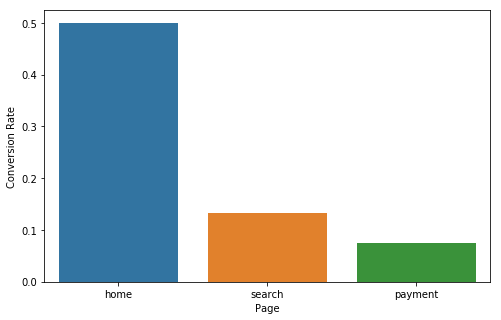

In [13]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=overall_conv, ax=ax)
plt.show()

### 2. Device

In [14]:
print(data['device'].unique())

['Desktop' 'Mobile']


In [15]:
desk_rates = conversion_rate(data[data['device'] == 'Desktop'])
mobile_rates = conversion_rate(data[data['device'] == 'Mobile'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Desktop', 'Mobile'))
print('-' * 40)
for name, desk_rate, mobile_rate in zip(names, desk_rates, mobile_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, desk_rate, mobile_rate))

   Page    |  Desktop   |   Mobile  
----------------------------------------
home       |   0.500000 |   0.500000
search     |   0.100000 |   0.200000
payment    |   0.049834 |   0.100000


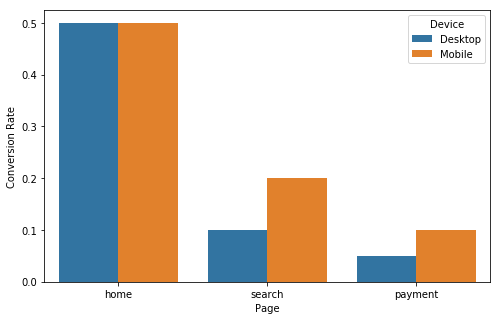

In [16]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Device': ['Desktop', 'Desktop', 'Desktop', 'Mobile', 'Mobile', 'Mobile'], 
        'Conversion Rate': desk_rates + mobile_rates}
device_conv = pd.DataFrame(maps, columns=['Page', 'Device', 'Conversion Rate'])

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=device_conv, ax=ax, hue='Device')
plt.show()

### 3. Sex

In [17]:
print(data['sex'].unique())

['Female' 'Male']


In [18]:
male_rates = conversion_rate(data[data['sex'] == 'Male'])
female_rates = conversion_rate(data[data['sex'] == 'Female'])
names = ['home', 'search', 'payment']
print('{0:^10s} | {1:^10s} | {2:^10s}'.format('Page', 'Male', 'Female'))
print('-' * 40)
for name, male_rate, female_rate in zip(names, male_rates, female_rates):
    print('{0:10s} | {1:10.6f} | {2:10.6f}'.format(name, male_rate, female_rate))

   Page    |    Male    |   Female  
----------------------------------------
home       |   0.496944 |   0.503073
search     |   0.130083 |   0.136708
payment    |   0.072014 |   0.077742


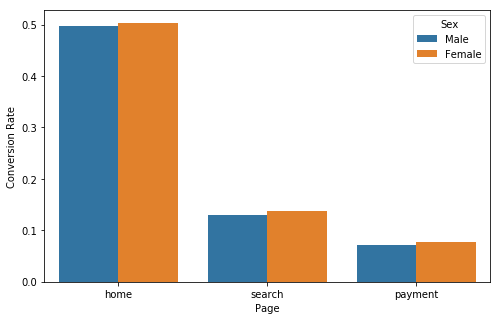

In [19]:
# Visualization
maps = {'Page': ['home', 'search', 'payment', 'home', 'search', 'payment'], 
        'Sex': ['Male', 'Male', 'Male', 'Female', 'Female', 'Female'], 
        'Conversion Rate': male_rates + female_rates}
sex_conv = pd.DataFrame(maps, columns=['Page', 'Sex', 'Conversion Rate'])

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x='Page', y='Conversion Rate', data=sex_conv, ax=ax, hue='Sex')
plt.show()